In [206]:
# 必要なパッケージを呼び出す
using Printf
using NLsolve
using Interpolations
using Plots
using Random
using Distributions
using LaTeXStrings

In [207]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
struct Model{TI<:Integer, TF<:AbstractFloat}

    # カリブレーション
    alpha::TF 
    beta::TF           
    delta::TF 
    Abar::TF

    # 定常状態の値
    kss::TF
    css::TF    
    
    # 移行過程に関する変数
    T::TI

end

In [208]:
function shooting(m,x,k0)
    """
    ------------------------------------------------------
    === ためし打ち法において、消費と資本の流列を求める関数 ===
    ------------------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・c0: 消費の初期値
    ・k0: 資本の初期値
    <output>
    ・k: 資本の流列
    ・c: 消費の流列
    """
    
    c0 = x[1];
    k = zeros(m.T+1);
    c = zeros(m.T+1);

    k[1] = k0;
    c[1] = c0;

    for t in 1:T

        k[t+1] = max(m.Abar*k[t]^m.alpha + (1-m.delta)*k[t] - c[t], 0.0); # k>0
        #k[t+1] = m.Abar*(k[t]^m.alpha) + (1-m.delta)*k[t] - c[t];

        #if k[t+1] <0
        #    k[m.T+1] = m.kss - 10.0
        #    break
        #end

        c[t+1] = m.beta*c[t]*(1 + m.Abar*m.alpha*k[t+1]^(m.alpha-1) - m.delta);

    end

    return k, c
end

shooting (generic function with 1 method)

In [209]:
function shooting_err(m,x,k0)
    """
    --------------------------------------------------------------
    === ためし打ち法において、資本の定常状態とk_{T}の差を求める関数 ===
    --------------------------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・c0: 消費の初期値
    ・k0: 資本の初期値
    <output>
    ・err: 資本の定常状態とk_{T}の差
    """

    k, c = shooting(m,x,k0);
    err = k[m.T+1] - m.kss;

    return err
end

shooting_err (generic function with 1 method)

### ためし打ち法で移行過程を求める
(saddlepath_shooting.m に対応)

In [210]:
# カリブレーション
alpha = 0.4; 
beta = 0.96;
delta = 1.0; 
Abar = 1.0;

# 定常状態の値
kss = (alpha*beta*Abar/(1-beta*(1-delta)))^(1/(1-alpha));
css = kss^alpha - delta*kss;

# 移行過程に関する変数
T = 30; 

# k の初期値
k0 = 0.1; 

In [211]:
m = Model(alpha,beta,delta,Abar,kss,css,T);
c0 = 0.129139420765888;

# 1. using nlsolve
c0 = nlsolve(x->shooting_err(m,x,k0),[c0],ftol=1e-16).zero;
k,c = shooting(m,c0,k0);

k

31-element Vector{Float64}:
   0.1
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

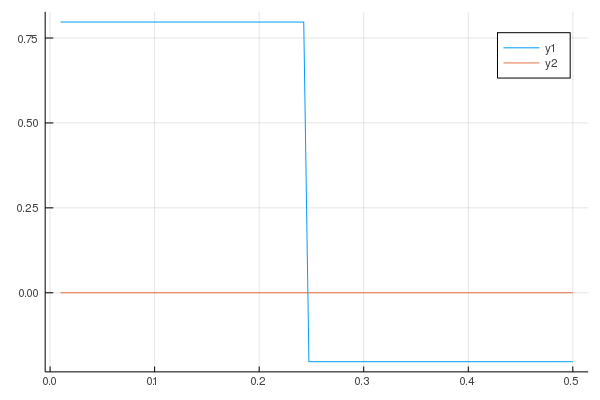

In [212]:
x = collect(range(0.01,0.5,length=100));
res = zeros(100)

for i in 1:100
    res[i] = shooting_err(m,x[i],k0)
end

plot(x,res)
plot!(x,zeros(100))

In [213]:
# 2. bisection
cL = 0.20;
cH = 0.30;
maxiter = 1000
tol = 1e-10
dif = 1.0
it = 1

while (it < maxiter) && (dif > tol)

    c0 = (cL+cH)/2;
    k,c = shooting(m,c0,k0);
    err = k[m.T+1] - kss;
    println([it,err])
    flush(stdout)

    if err > 0
        cL = copy(c0);
    else
        cH = copy(c0);
    end

    dif = abs(cH-cL);
    it += 1; 

end

c0

[1.0, -0.20287041017208585]


[2.0, 0.7971295895267118]


[3.0, 0.797129589049874]


[4.0, 0.7971295861049025]


[5.0, -0.20287041017208585]


[6.0, -0.20287041017208585]


[7.0, 0.7971295823333182]


[8.0, 0.7971295738533207]


[9.0, 0.7971295499936976]


[10.0, 0.7971293774063828]


[11.0, -0.20287041017208585]


[12.0, -0.20287041017208585]


[13.0, 0.7971290492693374]


[14.0, 0.7971259130890643]


[15.0, -0.20287041017208585]


[16.0, -0.20287041017208585]


[17.0, 0.7971034214907737]


[18.0, -0.20287041017208585]


[19.0, -0.20287041017208585]


[20.0, 0.7967054997135958]


[21.0, -0.20287041017208585]


[22.0, -0.20287041017208585]


[23.0, -0.20287041017208585]


[24.0, -0.20287041017208585]


[25.0, 0.7960086872899835]


[26.0, -0.20287041017208585]


[27.0, 0.7950641961578607]


[28.0, 0.7933178841145822]


[29.0, 0.7900364677073926]


[30.0, 0.783608202772546]


0.2452340169809759